# Preprocessing Retail Transaction Dtaset

In [0]:
## Checking pyspark installation
import pyspark

In [0]:
## Libraries importation
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, MapType, DateType, FloatType,BooleanType
from pyspark.sql import functions as F

### Connect to S3 to get data

In [0]:
spark.conf.set("fs.s3a.access.key", "")
spark.conf.set("fs.s3a.secret.key", "")
spark.conf.set("fs.s3a.endpoint", "s3.amazonaws.com")

In [0]:
## Create spark session 
spark = SparkSession.builder.appName("transactions1").getOrCreate()

In [0]:
## Check our data
df = spark.read.option('header', True).csv('s3://retail-transactions/transactions.csv')
df.show(1)

+--------------+-------------------+-------------+--------------------+-----------+----------+--------------+-----------+--------------+----------------+-----------------+------+---------+
|Transaction_ID|               Date|Customer_Name|             Product|Total_Items|Total_Cost|Payment_Method|       City|    Store_Type|Discount_Applied|Customer_Category|Season|Promotion|
+--------------+-------------------+-------------+--------------------+-----------+----------+--------------+-----------+--------------+----------------+-----------------+------+---------+
|    1000000000|2022-01-21 06:27:29| Stacey Price|['Ketchup', 'Shav...|          3|     71.65|Mobile Payment|Los Angeles|Warehouse Club|            True|        Homemaker|Winter|     None|
+--------------+-------------------+-------------+--------------------+-----------+----------+--------------+-----------+--------------+----------------+-----------------+------+---------+
only showing top 1 row



### create custom schema for data

In [0]:

custom_schem = StructType([
    StructField('Transaction_ID', IntegerType(), False),
    StructField('Date', DateType(), True),
    StructField('Customer_Name', StringType(), True),
    StructField('Product', StringType(), True),
    StructField('Total_Items', IntegerType(), True),
    StructField('Total_Cost', FloatType(), True),
    StructField('Payment_Method', StringType(), True),
    StructField('City', StringType(), True),
    StructField('Store_Type', StringType(), True),
    StructField('Discount_Applied', BooleanType(), True),
    StructField('Customer_Category', StringType(), True),
    StructField('Season', StringType(), True),
    StructField('Promotion', StringType(), True),
])

### create Dataframe using the created scema

In [0]:
## Create dataframe form csv file
df = spark.read.option('header', True).schema(custom_schem).csv('s3://retail-transactions/transactions.csv')

In [0]:
# Show the DataFrame
df.show()

+--------------+----------+-----------------+--------------------+-----------+----------+--------------+-------------+-----------------+----------------+-----------------+------+--------------------+
|Transaction_ID|      Date|    Customer_Name|             Product|Total_Items|Total_Cost|Payment_Method|         City|       Store_Type|Discount_Applied|Customer_Category|Season|           Promotion|
+--------------+----------+-----------------+--------------------+-----------+----------+--------------+-------------+-----------------+----------------+-----------------+------+--------------------+
|    1000000000|2022-01-21|     Stacey Price|['Ketchup', 'Shav...|          3|     71.65|Mobile Payment|  Los Angeles|   Warehouse Club|            true|        Homemaker|Winter|                None|
|    1000000001|2023-03-01| Michelle Carlson|['Ice Cream', 'Mi...|          2|     25.93|          Cash|San Francisco|  Specialty Store|            true|     Professional|  Fall|BOGO (Buy One Get...|


### Handle Missing Values Using Imputer Class


In [0]:
from pyspark.ml.feature import Imputer

In [0]:
### Handle Missing Numerical Values ###
imputer = Imputer(inputCols=['Total_Items','Total_Cost'], outputCols=['_Total_Items','_Total_Cost']).setStrategy("mean")
df = imputer.fit(df).transform(df)

In [0]:
# Drop the old columns and rename the new ones in a single operation
df = df.drop('Total_Items', 'Total_Cost') \
       .withColumnRenamed('_Total_Items', 'Total_Items') \
       .withColumnRenamed('_Total_Cost', 'Total_Cost')

# Show the updated DataFrame
df.show()


+--------------+----------+-----------------+--------------------+--------------+-------------+-----------------+----------------+-----------------+------+--------------------+-----------+----------+
|Transaction_ID|      Date|    Customer_Name|             Product|Payment_Method|         City|       Store_Type|Discount_Applied|Customer_Category|Season|           Promotion|Total_Items|Total_Cost|
+--------------+----------+-----------------+--------------------+--------------+-------------+-----------------+----------------+-----------------+------+--------------------+-----------+----------+
|    1000000000|2022-01-21|     Stacey Price|['Ketchup', 'Shav...|Mobile Payment|  Los Angeles|   Warehouse Club|            true|        Homemaker|Winter|                None|          3|     71.65|
|    1000000001|2023-03-01| Michelle Carlson|['Ice Cream', 'Mi...|          Cash|San Francisco|  Specialty Store|            true|     Professional|  Fall|BOGO (Buy One Get...|          2|     25.93|


In [0]:
# Define the categorical columns for which you want to handle missing values
categorical_cols = ['Promotion', 'Season', 'Customer_Category', 'Store_Type', 'City', 'Payment_Method']

# Loop through each categorical column to calculate the mode and fill missing values
for col_name in categorical_cols:
    # Calculate the most frequent value (mode) for the column
    mode_value = df.groupBy(col_name).agg(F.first(col_name).alias("most_frequent_value"), 
                                          F.count(col_name).alias("count")) \
                    .orderBy(F.desc("count")) \
                    .first()[0]  # Get the mode value
    
    # Fill missing values in the column with the mode
    df = df.na.fill({col_name: mode_value})


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

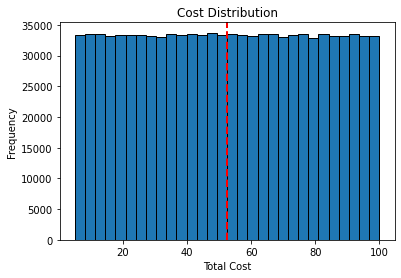

In [0]:
# Convert the relevant column to Pandas DataFrame
total_costs = df.select(col('Total_Cost')).toPandas()['Total_Cost']

# Plot the histogram of 'Total_Cost'
plt.hist(total_costs, bins=30, edgecolor='black')
plt.axvline(total_costs.mean(), color="red", linewidth=2, linestyle='--')  # Plot the mean
plt.title("Cost Distribution")
plt.xlabel("Total Cost")
plt.ylabel("Frequency")
plt.show()


## Features enginering

In [0]:
# Extract Date Features
df = df.withColumn('Year', F.year('Date')) \
                       .withColumn('Month', F.month('Date')) \
                       .withColumn('Day', F.dayofmonth('Date')) \
                       .withColumn('DayOfWeek', F.dayofweek('Date')) \
                       .withColumn('IsWeekend', (F.dayofweek('Date') >= 6).cast('int'))  # 1 = Sunday, 7 = Saturday

In [0]:
# Create Interaction Features
df = df.withColumn('Total_Cost_Per_Item', 
                                    df['Total_Cost'] / df['Total_Items'])

In [0]:

# 4. Create Text Features (example if Customer_Name is a text column)
df = df.withColumn('Customer_Name_Length', F.length('Customer_Name'))

In [0]:
# Aggregating Features (example: average Total_Cost by Customer_Category)
average_cost_by_category = df.groupBy('Customer_Category') \
                                      .agg(F.avg('Total_Cost').alias('Avg_Total_Cost'))

# Join back the average feature to the original DataFrame
df = df.join(average_cost_by_category, on='Customer_Category', how='left')

In [0]:
# Show the DataFrame after feature generation
df.show()

+-----------------+--------------+----------+-----------------+--------------------+--------------+-------------+-----------------+----------------+------+--------------------+-----------+----------+----+-----+---+---------+---------+-------------------+--------------------+-----------------+
|Customer_Category|Transaction_ID|      Date|    Customer_Name|             Product|Payment_Method|         City|       Store_Type|Discount_Applied|Season|           Promotion|Total_Items|Total_Cost|Year|Month|Day|DayOfWeek|IsWeekend|Total_Cost_Per_Item|Customer_Name_Length|   Avg_Total_Cost|
+-----------------+--------------+----------+-----------------+--------------------+--------------+-------------+-----------------+----------------+------+--------------------+-----------+----------+----+-----+---+---------+---------+-------------------+--------------------+-----------------+
|         Teenager|    1000000020|2021-10-31|     Angela Jones|['Pancake Mix', '...|          Cash|      Houston|     

## Sve the result in to my SnowFlake account

In [0]:
# Save the DataFrame to DBFS as Parquet
# df.write.mode("overwrite").parquet("/dbfs/tmp/imputed_data.parquet")

In [0]:
# Define Snowflake connection options
snowflake_options = {
    "sfURL": "",  # Replace with your Snowflake account URL
    "sfDatabase": "transactions_db",  # Replace with your Snowflake database name
    "sfSchema": "transactions_schema",  # Replace with your Snowflake schema name
    "sfWarehouse": "transactions_warehouse",  # Replace with your Snowflake warehouse name
    "sfRole": "accountrole",  # Optional: Specify your Snowflake role if necessary
    "sfUser": "",  # Replace with your Snowflake username
    "sfPassword": ""  # Replace with your Snowflake password
}

#Write DataFrame to Snowflake
df.write.format("snowflake").options(**snowflake_options).option("dbtable","ttrans").mode("overwrite").save()


### Confirm the data has been written

In [0]:

# You can read back from Snowflake to confirm the write operation
df_snowflake = spark.read \
    .format("snowflake") \
    .options(**snowflake_options) \
    .option("dbtable","ttrans") \
    .load()

df_snowflake.show()  # Display the data from Snowflake